In [1]:
import numpy    as np
from numpy.testing._private.utils import decorate_methods
import pandas   as pd
import seaborn  as sns
import matplotlib.pyplot as plt
import sklearn  as skl
import time

from sklearn.pipeline import Pipeline      # Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import set_config
set_config(display='diagram') # Useful for display the pipeline

from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.ensemble      import AdaBoostRegressor
from sklearn.ensemble      import GradientBoostingRegressor
from xgboost               import XGBRegressor
from lightgbm              import LGBMRegressor
from catboost              import CatBoostRegressor

In [3]:
data = pd.read_csv(r'data\london_merged.csv')
data['year'] = data['timestamp'].apply(lambda row: row[:4])
data['month'] = data['timestamp'].apply(lambda row: row.split('-')[2][:2] )
data['hour'] = data['timestamp'].apply(lambda row: row.split(':')[0][-2:] )
data.drop('timestamp', axis=1, inplace=True)
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,04,00
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,04,01
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,04,02
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,04,03
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,04,04


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'is_holiday'),
  Text(0, 1, 'is_weekend'),
  Text(0, 2, 'season'),
  Text(0, 3, 'wind_speed'),
  Text(0, 4, 'weather_code'),
  Text(0, 5, 't2'),
  Text(0, 6, 't3'),
  Text(0, 7, 't1'),
  Text(0, 8, 'hum'),
  Text(0, 9, 'cnt')])

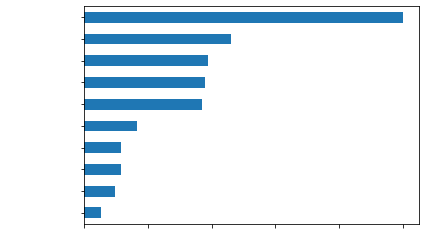

In [40]:
%matplotlib inline
data.corr()['cnt'].abs().sort_values().plot(kind = 'barh')
plt.xticks(color = 'white')
plt.yticks(color = 'white')


In [24]:
wind_chill_t3 = []
for i in data.index:
    temp = (data['t1'].iloc[i]*(9/5))+32
    wind = (data['wind_speed'].iloc[i])*0.6213
    if wind>0:
        wind_chill = 35.74+(0.6215*temp)-(35.75*(wind**0.16))+(0.4275*temp*(wind**0.16))
        c_wc = (wind_chill-32)*(5/9)
        wind_chill_t3.append(round(c_wc,1))
    else:
        wind_chill_t3.append(0)
wind_chill_t3[2]
data['t3'] = wind_chill_t3
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour,t3
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,04,00,1.4
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,04,01,1.8
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,04,02,0.0
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,04,03,0.0
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,04,04,0.1


In [25]:
def data_enhancement(data):
    
    gen_data = data
    
    for season in data['season'].unique():
        seasonal_data =  gen_data[gen_data['season'] == season]
        hum_std = seasonal_data['hum'].std()
        wind_speed_std = seasonal_data['wind_speed'].std()
        t1_std = seasonal_data['t1'].std()
        t2_std = seasonal_data['t2'].std()
        t3_std = seasonal_data['t3'].std()
        
        for i in gen_data[gen_data['season'] == season].index:
            if np.random.randint(2) == 1:
                gen_data['hum'].values[i] += hum_std/10
            else:
                gen_data['hum'].values[i] -= hum_std/10
                
            if np.random.randint(2) == 1:
                gen_data['wind_speed'].values[i] += wind_speed_std/10
            else:
                gen_data['wind_speed'].values[i] -= wind_speed_std/10
                
            if np.random.randint(2) == 1:
                gen_data['t1'].values[i] += t1_std/10
            else:
                gen_data['t1'].values[i] -= t1_std/10
                
            if np.random.randint(2) == 1:
                gen_data['t2'].values[i] += t2_std/10
            else:
                gen_data['t2'].values[i] -= t2_std/10.

            if np.random.randint(2) == 1:
                gen_data['t3'].values[i] += t3_std/10
            else:
                gen_data['t3'].values[i] -= t3_std/10

    return gen_data

print(data.head(3))
gen = data_enhancement(data)
print(gen.head(3) )

   cnt   t1   t2   hum  wind_speed  weather_code  is_holiday  is_weekend  \
0  182  3.0  2.0  93.0         6.0           3.0         0.0         1.0   
1  138  3.0  2.5  93.0         5.0           1.0         0.0         1.0   
2  134  2.5  2.5  96.5         0.0           1.0         0.0         1.0   

   season  year month hour   t3  
0     3.0  2015    04   00  1.4  
1     3.0  2015    04   01  1.8  
2     3.0  2015    04   02  0.0  
   cnt        t1       t2        hum  wind_speed  weather_code  is_holiday  \
0  182  3.379372  2.48831  94.089517    6.890895           3.0         0.0   
1  138  2.620628  2.98831  91.910483    4.109105           1.0         0.0   
2  134  2.879372  2.98831  95.410483    0.890895           1.0         0.0   

   is_weekend  season  year month hour        t3  
0         1.0     3.0  2015    04   00  0.978602  
1         1.0     3.0  2015    04   01  2.221398  
2         1.0     3.0  2015    04   02  0.421398  


In [26]:
y = data['cnt']
x = data.drop(['cnt'], axis=1)


cat_vars = ['season','is_weekend','is_holiday','year','month','weather_code']
num_vars = ['t1','t2','hum','wind_speed', 't3']


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2,random_state=0) # Recommended for reproducibility

extra_sample = gen.sample(gen.shape[0] // 3)
x_train = pd.concat([x_train, extra_sample.drop(['cnt'], axis=1 ) ])
y_train = pd.concat([y_train, extra_sample['cnt'] ])

transformer = PowerTransformer()
y_train = transformer.fit_transform(y_train.values.reshape(-1,1))
y_val = transformer.transform(y_val.values.reshape(-1,1))                     

In [27]:
num_4_treeModels = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
])

cat_4_treeModels = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder()) # handle_unknown='ignore' ONLY IN VERSION 0.24
])

tree_prepro = ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

In [28]:
tree_classifiers = {
  "Decision Tree": DecisionTreeRegressor(),
  "Extra Trees":   ExtraTreesRegressor(n_estimators=100),
  "Random Forest": RandomForestRegressor(n_estimators=100),
  "AdaBoost":      AdaBoostRegressor(n_estimators=100),
  "Skl GBM":       GradientBoostingRegressor(n_estimators=100),
  "XGBoost":       XGBRegressor(n_estimators=100),
  "LightGBM":      LGBMRegressor(n_estimators=100),
  "CatBoost":      CatBoostRegressor(n_estimators=100),
}

tree_classifiers = {name: make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

results = pd.DataFrame({'Model': [],'r_score':[], 'MSE': [], 'MAB': [], " % error": [], 'Time': []})

In [29]:
rang = abs(y_train.max()) + abs(y_train.min())
for model_name, model in tree_classifiers.items():
    
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
        
    pred = model.predict(x_val)
    
    results = results.append({"Model":    model_name,
                              "r_score": r2_score(y_val, pred),
                              "MSE": mean_squared_error(y_val, pred),

                              "MAB": mean_absolute_error(y_val, pred),
                              " % error": mean_squared_error(y_val, pred) / rang,
                              "Time":     total_time},
                              ignore_index=True)

results_ord = results.sort_values(by=['MSE'], ascending=True, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['MSE', 'MAE'], vmin=0, vmax=100, color='#5fba7d')

print(results_ord)

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d 

Learning rate set to 0.42641
0:	learn: 0.8914841	total: 156ms	remaining: 15.4s
1:	learn: 0.8461854	total: 162ms	remaining: 7.95s
2:	learn: 0.8186550	total: 169ms	remaining: 5.45s
3:	learn: 0.8094292	total: 176ms	remaining: 4.24s
4:	learn: 0.8009270	total: 184ms	remaining: 3.5s
5:	learn: 0.7940550	total: 191ms	remaining: 2.99s
6:	learn: 0.7902885	total: 201ms	remaining: 2.67s
7:	learn: 0.7874335	total: 206ms	remaining: 2.37s
8:	learn: 0.7850522	total: 225ms	remaining: 2.28s
9:	learn: 0.7825018	total: 230ms	remaining: 2.07s
10:	learn: 0.7796222	total: 242ms	remaining: 1.96s
11:	learn: 0.7774368	total: 251ms	remaining: 1.84s
12:	learn: 0.7752085	total: 258ms	remaining: 1.73s
13:	learn: 0.7742320	total: 266ms	remaining: 1.63s
14:	learn: 0.7724158	total: 273ms	remaining: 1.55s
15:	learn: 0.7704854	total: 282ms	remaining: 1.48s
16:	learn: 0.7659913	total: 291ms	remaining: 1.42s
17:	learn: 0.7651501	total: 297ms	remaining: 1.35s
18:	learn: 0.7640197	total: 305ms	remaining: 1.3s
19:	learn: 0.7

In [30]:
results_ord

,Model,r_score,MSE,MAB,% error,Time
1,Extra Trees,0.627466,0.369292,0.372582,0.067135,4.842708
2,Random Forest,0.583259,0.413114,0.457215,0.075101,8.282907
3,XGBoost,0.456523,0.538747,0.558542,0.097940,1.728034
4,LightGBM,0.438388,0.556724,0.577509,0.101208,0.820059
5,CatBoost,0.424563,0.570429,0.582754,0.103700,2.247182
6,Skl GBM,0.374308,0.620246,0.612488,0.112756,2.467290
7,AdaBoost,0.301133,0.692785,0.662943,0.125943,0.663420
8,Decision Tree,0.249105,0.744360,0.516994,0.135319,0.236817
